<a id="top"></a>
# Surveying dust structure via GALEX MIS - Part 2
***

## Learning goals

By the end of this tutorial you will be able to:

- Create a mosaic from several GALEX MIS images
- Learn how to match images using their central coordinates 
- Use masks for circular images

## Introduction

**GALEX background**: The Galaxy Evolution Explorer (GALEX) was a satellite which mission was to produce an All-sky Imaiging Survey (AIS). It observed the sky in two different bands: in the Near UV (NUV) ($1750-27504$ Å) and in the Far UV (FUV) ($1350-1750$ Å). The GALEX database contains over 600 million source measurements in the ultraviolet domain, with some sources having more than one measurement, which could be useful to look for variability. 

**GALEX Medium Imaging survey (MIS) background**: Single orbit exposures (1,500s) of 1000 square degrees in positions that match the Sloan Digital Sky Survey (SDSS) spectroscopic footprint. The MIS has been extended to cover the Two Degree Field Galaxy Redshift Survey (2dFGRS) and the AA-Omega (WiggleZ) project.

**Defining some terms:**

- **MIVC**: Molecular Intermediate Velocity Cloud.
- **Intensity map**: image that displays the photons per pixel per second corrected for the relative response of the instrument used. 

## Table of Contents
* [Imports](#Imports)
* [Target: Draco MIVC](#Target:-Draco-MIVC)
* [GALEX MIS - Coordinate query](#GALEX-MIS---Coordinate-query)
* [Constructing the mosaic](#Constructing-the-mosaic)
    * [Checking orientation](#Checking-orientation)
    * [Saving images to local](#Saving-images-to-local)
    * [Mask](#Mask)
    * [Expanded image](#Expanded-image)
    * [Limits of image - Coordinates](#Limits-of-image---Coordinates)
    * [Transforming RA/Dec into image coordinates](#Transforming-RA/Dec-into-image-coordinates)
    * [Final mosaic](#Final-mosaic)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports

- `astropy` to use tools needed for performing astronomy and astrophysics with Python, including handling fits files, defining coordinates or choosing the right limits for image visualization.
- `Observations` from _astroquery.mast_ to query the Barbara A. Mikulski Archive for Space Telescopes (MAST).
- `os` to  use operating system dependent functionality, such as unzipping files.
- `matplotlib` to visualize images.
- `numpy` to manipulate arrays.
- `PIL` to combine multiple images together

In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.mast import Observations
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.visualization import ZScaleInterval
import numpy as np
from PIL import Image, ImageDraw

## Target: Draco MIVC

The objective of this tutorial is to create a mosaic of a high-latitude cloud using different NUV images retrieved from GALEX MIS. The GALEX MIS products can be accesed through _astroquery.mast_. The whole process to get an individual image and display it is explained in Part 1 of this tutorial, the reader is encouraged to complete the previous tutorial before continuing this one if they haven't done it yet. 

Now, let's start with our target, <a href="http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%40375027&Name=NAME%20Draco%20Nebula&submit=submit">the Draco Nebula</a>. 

## GALEX MIS - Coordinate query

Below we can find a function that was developed in Part 1 of this tutorial to retrieve the images from GALEX database, for further information please refer to the previous tutorial.

In [2]:
def getImages(RA,Dec,prod_name):
    
    """
    Obtains image from GALEX MIS database, computes limits of coordinates in axes and contrast values for image display

    Inputs:
    :param RA, Dec: coordinates of target (Right Ascension and Declination)
    :type RA, Dec: float
    :param prod_name: product filename
    :type prod_name: string
    
    Outputs: 
    :return: image 
    :rtype: ndarray
    :return: header
    :rtype: 
    :return: RA1, RAf, Dec1, Decf - Limits of coordinates in axes
    :rtype: float
    :return: vmin, vmax - Contrast values for image display
    :rtype: float
    :return: crval1/2 - Central coordinate value of image (Right Ascension/Declination)
    :rtype: float
    """
    
    coord = SkyCoord(RA, Dec, unit='deg', frame='icrs')
    obs = Observations.query_criteria(obs_collection="GALEX",coordinates=coord,project='MIS',radius="1 deg")
    
    data_products = Observations.get_product_list(obs)
    data_products_mrp = Observations.filter_products(data_products,productFilename = prod_name, productType='SCIENCE',productGroupDescription='Minimum Recommended Products')
    yourProd = data_products_mrp[0]
    table = Observations.download_products(yourProd, mrp_only = False, cache = False) 
    
    filename = table['Local Path'][0]
    os.system("gunzip " + filename)
    
    with fits.open(filename[:-3]) as hdulist: 
        header = hdulist[0].header
        image = hdulist[0].data
        
    naxis1 = header['NAXIS1']
    naxis2 = header['NAXIS2']
    cdelt1 = header['CDELT1']
    cdelt2 = header['CDELT2']
    crpix1 = header['CRPIX1']
    crpix2 = header['CRPIX2']
    crval1 = header['CRVAL1']
    crval2 = header['CRVAL2']
    
    # Initial RA - Pixel 1
    RA1 = crval1 - (crpix1-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
    # Final RA - Last Pixel 
    RAf = crval1 + (naxis1+1-crpix1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
    
    # Initial Dec - Pixel 1
    Dec1 = crval2 - (crpix2-1)*cdelt2
    # Final Dec - Last Pixel 
    Decf = crval2 + (naxis2+1-crpix2)*cdelt2
    
    cut = image[1850:-1850,1850:-1850]
    interval = ZScaleInterval(nsamples=cut.size, contrast=1.5, max_reject=0.5)
    vmin, vmax = interval.get_limits(cut)
    
    return image, header, RA1, RAf, Dec1, Decf, vmin, vmax, crval1, crval2

Now that we have the function, let's load the parameters we need for our query first:

In [3]:
RA_draco = np.array([253.0000,255.34705, 253.0000, 255.0000, 256.27741,250.84045])
Dec_draco = np.array([61.0, 62.03394, 63.0, 60.0,61.21117,63.80299])
prod_draco = np.array(['MISDR1_10131_0351-nd-int.fits.gz','MISGCSN2_10096_0002-nd-int.fits.gz','MISDR1_10031_0349-nd-int.fits.gz','MISDR1_10166_0351-nd-int.fits.gz','MISGCSN1_10130_0004-nd-int.fits.gz','MISDR1_10032_0349-nd-int.fits.gz'])

And finally, let's retrieve the images:

In [4]:
n = len(RA_draco)

images_draco = []
header_draco = []
RA1_draco = np.zeros(n)
RAf_draco = np.zeros(n)
Dec1_draco = np.zeros(n)
Decf_draco = np.zeros(n)
vmin_draco = np.zeros(n)
vmax_draco = np.zeros(n)
RAc_draco = np.zeros(n)
Decc_draco = np.zeros(n)

for i in range(n):
    image_dr, header_dr, RA1_draco[i], RAf_draco[i], Dec1_draco[i], Decf_draco[i], vmin_draco[i], vmax_draco[i], RAc_draco[i], Decc_draco[i] = getImages(RA_draco[i],Dec_draco[i],prod_draco[i])
    images_draco.append(image_dr)
    header_draco.append(header_dr)

## Constructing the mosaic

### Checking orientation

Since we want to construct a mosaic with different images, we need to make sure all of them are oriented in the same way. This information is contained in the header of the images. The parameter 'CROTA2' refers to the rotation of the horizontal and vertical axes in degrees. So let's check all our images:

In [16]:
for i in range(len(header_draco)):
    print('Image '+str(i+1)+': '+repr(header_draco[i][23:24]))

Image 1: CROTA2  =                   0.                                                  
Image 2: CROTA2  =                   0.                                                  
Image 3: CROTA2  =                   0.                                                  
Image 4: CROTA2  =                   0.                                                  
Image 5: CROTA2  =                   0.                                                  
Image 6: CROTA2  =                   0.                                                  


Great! This means all of our images are oriented in the same way, so we can directly work with them without having to perform any rotation.

### Saving images to local

Now let's save the rest of the images too:

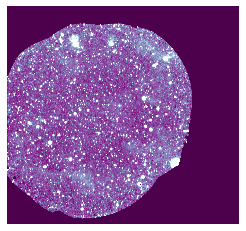

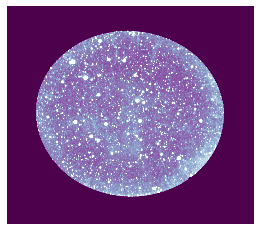

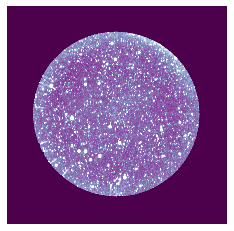

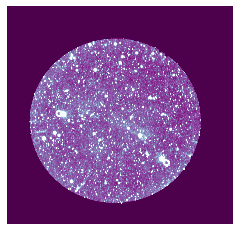

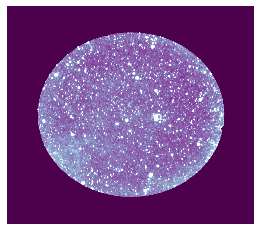

In [17]:
for i in range(1,len(RA1_draco)):
    plt.figure()
    ax = plt.gca()
    plt.imshow(images_draco[i], extent=[RA1_draco[i], RAf_draco[i], Dec1_draco[i], Decf_draco[i]], vmin=vmin_draco[0], vmax=vmax_draco[0], cmap='BuPu_r',aspect=2)
    im_i = i + 2
    ax.axis('off')
    plt.savefig('draco'+str(im_i)+'.jpg',bbox_inches='tight',dpi=1000)
    plt.show()

### Mask

Let's create a mask for each image in the form of a circle. We will use this to only paste the circular part of the Draco images, which is where the actual image is contained, into the mosaic. For this we will use `Image.new()`, this method creates a new image for a given mode, in our case "L" because we will create it in black and white, and size, which will be the same as its corresponding image. 

In this new image we will then draw a circle, which will be our actual mask, for this we will use `draw.ellipse()`. The parameters that we need to provide are the four points to define the box in which the ellipse will be contained and the parameter _fill_ specifies the color with which the form will be filled. Since we are using the black and white mode, it does not really matter as long as it is different from black, so we can use any color.

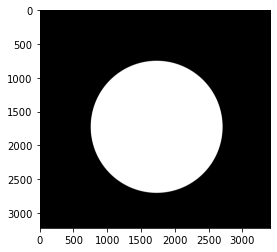

In [16]:
mask_im = []
n = len(RA_draco)

for i in range(n):
    in_i = i + 2
    im2 = Image.open('draco'+str(in_i)+'.jpg')
    mask = Image.new("L", im2.size)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((750, 750, 2700, 2700), fill=255)
    mask_im.append(mask)

plt.figure()
plt.imshow(mask_im[0],cmap='binary_r')
plt.show()

### Expanded image

In order to create our mosaic, let's add zeros to our central image to expand the field of view. We will use this expanded image to paste the additional images in it.

In [6]:
w = len(images_draco[0])
new_zeros = np.zeros((w,w))
new_image = np.append(images_draco[0], new_zeros, axis = 0)
new_image2 = np.insert(new_image,0,new_zeros,axis= 0)
new_zeros2 = np.zeros((w,3*w))
new_image3 = np.insert(new_image2,0,new_zeros2,axis= 1)
new_image4 = np.insert(new_image3,2*w,new_zeros2,axis= 1)

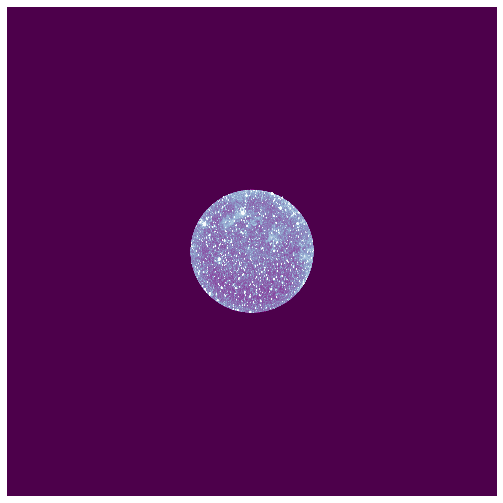

In [14]:
plt.figure(figsize = (9,9))
ax = plt.gca()
plt.imshow(new_image4, vmin=vmin_draco[0], vmax=vmax_draco[0], cmap='BuPu_r')
ax.invert_yaxis()
ax.axis('off')
plt.savefig('expanded.jpg',pad_inches=0,bbox_inches='tight',dpi=1100)
plt.show()

### Limits of image - Coordinates

We need to update the limits of the expanded image, which is 3 times the size of our original one, so we can simply do the following:

In [20]:
naxis1 = header_draco[0]['NAXIS1']
naxis2 = header_draco[0]['NAXIS2']
cdelt1 = header_draco[0]['CDELT1']
cdelt2 = header_draco[0]['CDELT2']
crpix1 = header_draco[0]['CRPIX1']
crpix2 = header_draco[0]['CRPIX2']
crval1 = header_draco[0]['CRVAL1']
crval2 = header_draco[0]['CRVAL2']

# Initial RA - Pixel 1
RA1 = crval1 - (crpix1*3-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
# Final RA - Last Pixel 
RAf = crval1 + (crpix1*3-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))

# Initial Dec - Pixel 1
Dec1 = crval2 - (crpix2*3-1)*cdelt2
# Final Dec - Last Pixel 
Decf = crval2 + (crpix2*3-1)*cdelt2

### Transforming RA/Dec into image coordinates

We know the center of the additional images in the form (RA, Dec), but when we use the method `paste` from the `PIL` package, we need to specify the coordinates corresponding to the image location. In addition, the center (0,0) of the image coordinates is not exactly placed in the middle, let's see this through an example using the expanded image and one of the additional ones from the Draco cloud:

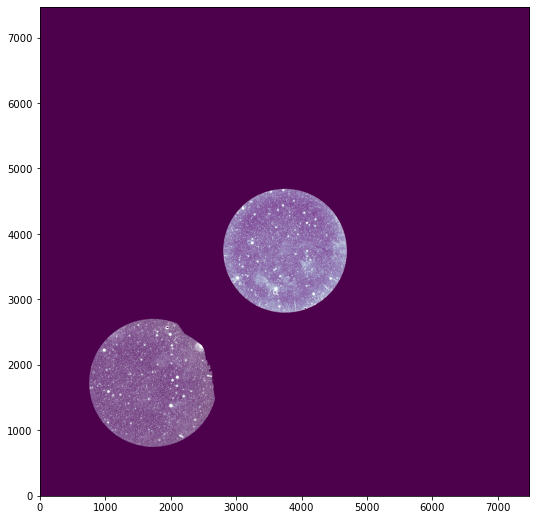

In [26]:
im_exp = Image.open('expanded.jpg')
im2 = Image.open('draco2.jpg')

im_exp.paste(im2,(0,0),mask_im[0])

plt.figure(figsize=(9,9))
ax = plt.gca()
plt.imshow(im_exp)
ax.invert_yaxis()
plt.show()

See how the additional image that corresponds to the (0,0) coordinates is placed towards the lower left? Actually these (0,0) coordinates would correspond to what we would think is the (1750,1750) image coordinates. In other words, the lower left corner of this image corresponds to the (-1750,-1750) image coordinate.

By knowing this, we can create a function that will automatically transform the central coordinates of our images into in the (RA,Dec) format into the correct image ones:

In [27]:
def getImCoord(coord_RA,coord_Dec, RA1, RAf, Dec1, Decf):
    
    """
    Transforms coordinates in (RA, Dec) format into image coordinates to be used as input for the paste method from PIL
    Inputs:
    :param coord_RA, coord_Dec: coordinates of target (Right Ascension and Declination)
    :type coord_RA, coord_Dec: float
    :param RA/Dec1, RA/Decf: coordinate limits of image for the RA/Dec axis
    :type prod_name: float
    
    Outputs: 
    :return: ImCoord_RA, ImCoord_Dec - Image coordinates
    :rtype: float
    """
    
    RAx = np.array([RA1,RAf])
    pixx = np.array([-1750,5750])
    m_RA, b_RA = np.polyfit(RAx, pixx, 1)
    ImCoord_RA = m_RA*coord_RA+b_RA
    
    Decx = np.array([Dec1,Decf])
    pixy = np.array([-1750,5750])
    m_Dec, b_Dec= np.polyfit(Decx, pixy, 1)
    ImCoord_Dec = m_Dec*coord_Dec+b_Dec
    
    return ImCoord_RA, ImCoord_Dec

In [29]:
Im_RA = np.zeros(n)
Im_Dec = np.zeros(n)

for i in range(1,n):
    Im_RA[i], Im_Dec[i] = getImCoord(RAc_draco[i],Decc_draco[i], RA1, RAf, Dec1, Decf)
    print('(RA, Dec) = ('+str(RAc_draco[i])+','+str(Decc_draco[i])+') deg -> ('+str(Im_RA[i])+','+str(Im_Dec[i])+')')

(RA, Dec) = (254.906492,62.009663) deg -> (1395.1557651624607,3221.6173943234026)
(RA, Dec) = (253.15369,63.8054) deg -> (2713.282767845347,6027.212915545504)
(RA, Dec) = (255.06516,60.34843) deg -> (1275.8356278841675,626.1661314121884)
(RA, Dec) = (256.2067,61.1695) deg -> (417.38458855249337,1908.9766513323411)
(RA, Dec) = (250.84674,63.8054) deg -> (4448.135357492807,6027.212915545504)


### Final mosaic

Now that we have all the ingredients to construct the final mosaic, let's put it all together:

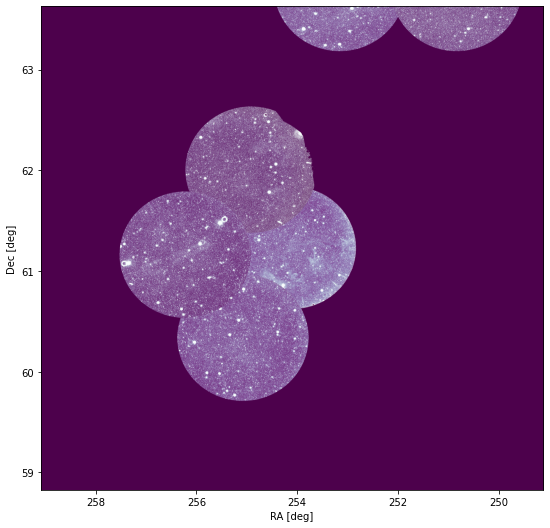

In [31]:
im_exp = Image.open('expanded.jpg')
images = []

for i in range(1,n):
    im = Image.open('draco'+str(2+i)+'.jpg')
    im_exp.paste(im,(int(Im_RA[i]), int(Im_Dec[i])), mask_im[i])

plt.figure(figsize=(9,9))
ax = plt.gca()
plt.imshow(im_exp, extent=[RA1,RAf,Decf,Dec1],aspect=2)
ax.invert_yaxis()
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.savefig('Draco_mosaic.jpg',bbox_inches='tight',dpi = 1100)
plt.show()

## Exercises

Now that we have seen the whole process, let's try to do the same for a different target. Let's study now **TBD**. The following coordinates and names for the files needed are already provided below to simplify the exercises:

In [ ]:
RA = np.array([])
Dec = np.array([])
prod = np.array([])

### 1. Coordinate query and data download

Following the steps shown before, perform a query in the GALEX MIS database and download the NUV intensity map corresponding to the coordinates provided. You can use the function presented in the previous sections for this.

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 2. Check the orientation of the images

As we did before, check the orientation of the image and make the necessary adjustments if the orientations do not coincide:

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 3. Save non-central images to local

In order to use the `paste` method, we first need to save the additional images to our local. The central image is the fist one retrieved from the database, so let's save the rest of the images to our local in order to use them later. Remember you need to provide the filename which will be used to save the image to your local directory when using `savefig` from `matplotlib`.

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 4. Generate the masks for the circular images

Since we are working with circular images, in order to paste them into our extended image we need to only use the part of the image that actually contains information. In order to do this, let's use circular masks as before. In order to do this, create a circular mask for each of the images retrieved as shown previously.

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 5. Create an expanded image from the central one

Using the central image (the first one retrieved from the database), create an extended image by included 0s in the 2D array corresponding to the retrieved intensity map as we did before.

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 6. Obtain the limits of the expanded image

Using the technique introduced in Part 1 of this tutorial, and briefly used in this Part, obtain the new limits of the extended image we just created using the coordinates of the central image (RA, Dec).

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 7. Transform RA, Dec coordinates into image coordinates

As shown before, we need to transform the central coordiantes of the images in order to correctly place them in the mosaic. You can use the function proposed before in this section.

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 8. Display the final mosaic

Let's put together everything and display the final mosaic!

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used before here


## Additional Resources

For more information about the MAST archive and details about the tutorial: 

* <a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
* <a href="https://galex.stsci.edu/GR6/">GALEX via MAST</a> <br>

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Keyword(s)**: Tutorial, mosaic, dust <br>
**Last Updated**: Sep 2022 <br>
**Next review**: Apr 2023

For support, please contact the Archive HelpDesk at archive@stsci.edu.
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>